In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

RANDOM_SEED = 42

In [2]:
# Para la compatibilidad de GPU y tensorflow uso
# tensorflow==2.10.1
# cuda = 11.2
# cudnn = 8.1.1
# python = 3.10.9
# https://www.tensorflow.org/install/source_windows?#gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("GPUs Available: ", gpus)
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
      print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Especificación de cada ruta

In [3]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# Configuración del número de clasificaciones

In [4]:
NUM_CLASSES = 4

# Longitud de entrada

In [5]:
TIME_STEPS = 16
DIMENSION = 2

# Carga de datos de entrenamiento

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.50, random_state=RANDOM_SEED)

# Construcción del modelo

In [29]:
use_lstm = False
model = None

if use_lstm:
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [30]:
model.summary()  # keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                250       
                                                                 
 dense_5 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Callback de punto de control del modelo
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para detención temprana
es_callback = keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Callback para detención temprana
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo

In [33]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
71/83 [========================>.....] - ETA: 0s - loss: 1.3741 - accuracy: 0.4080
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.keras
83/83 [==============================] - 1s 9ms/step - loss: 1.3721 - accuracy: 0.4233 - val_loss: 1.3540 - val_accuracy: 0.5846
Epoch 2/1000
80/83 [===========================>..] - ETA: 0s - loss: 1.3353 - accuracy: 0.5422
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.keras
83/83 [==============================] - 1s 6ms/step - loss: 1.3344 - accuracy: 0.5427 - val_loss: 1.3054 - val_accuracy: 0.6945
Epoch 3/1000
70/83 [========================>.....] - ETA: 0s - loss: 1.2806 - accuracy: 0.5982
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.keras
83/83 [==============================] - 1s 6ms/step - loss: 1.2753 - accuracy: 0.5971 - val_loss: 1.2284 - val_accuracy: 0.7164
Epoch 4/1000
83/83 [==============================] - ETA: 0s - 

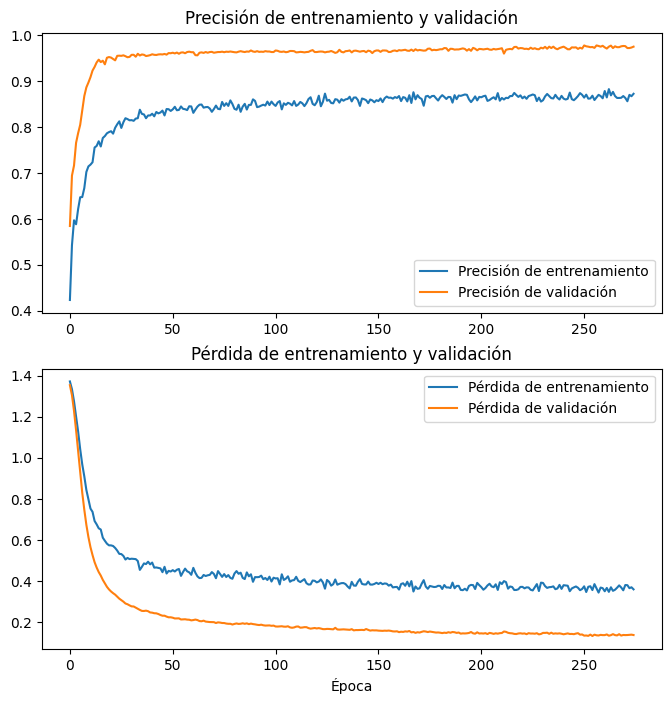

In [34]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

# Graficar la pérdida
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.show()

In [35]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

21/21 [==============================] - 0s 5ms/step - loss: 0.1369 - accuracy: 0.9755


In [36]:
# Carga del modelo guardado
model = keras.models.load_model(model_save_path)

In [37]:
# Prueba de inferencia
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 67ms/step
[0.94284225 0.01418926 0.01752595 0.02544257]
0


# Matriz de confusión

83/83 [==============================] - 0s 3ms/step


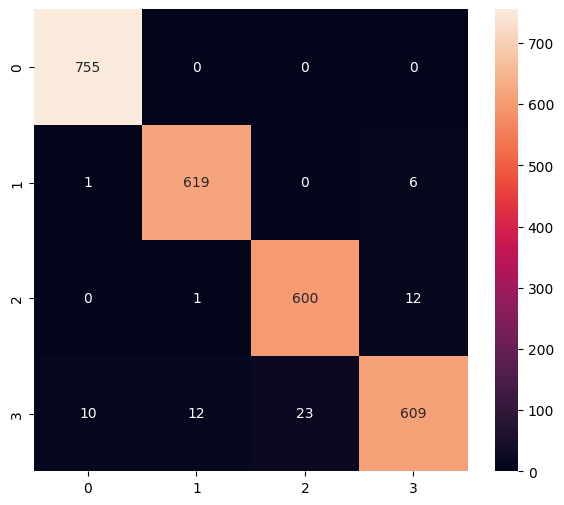

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       755
           1       0.98      0.99      0.98       626
           2       0.96      0.98      0.97       613
           3       0.97      0.93      0.95       654

    accuracy                           0.98      2648
   macro avg       0.97      0.97      0.97      2648
weighted avg       0.98      0.98      0.98      2648



In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [39]:
# Guardar el modelo para inferencia exclusiva
model.save(model_save_path, include_optimizer=False)
model = keras.models.load_model(model_save_path)

In [ ]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

# Convertir el modelo
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

# Prueba de inferencia

In [41]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [42]:
# Obtener tensores de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [43]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [66]:
%%time
# Realizar inferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [48]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.94278675 0.01420608 0.01755139 0.02545574]
0
